<a href="https://colab.research.google.com/github/mariemtouihri/GRAM-Metric/blob/main/GRAM_Metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from scipy.integrate import quad
import torch.nn.functional as F
from torch.autograd import Function

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# GRAM all correlations

In [ ]:
def read_correlations():

  X = {}

  types = ["pearson", "spearman", "ktau"]
  for corr_type in types:
    file_path = f'/content/drive/MyDrive/Colab_Notebooks/A_matrices/A_matrices_{corr_type}.npy'
    A_matrices = np.load(file_path)
    X[corr_type] = {}
    X[corr_type]["X_train"] = []
    X[corr_type]["X_test"] = []

    # Split data into training and testing sets
    X_train, X_test = train_test_split(A_matrices, test_size=0.2, random_state=42)

    X[corr_type]["X_train"] = X_train
    X[corr_type]["X_test"] = X_test

  return X




def gram_training(correlation, X, target_area1, target_area2, model):

  A_tensors = [torch.tensor(A, dtype=torch.float32) for A in X[correlation]["X_train"]]


  model = SurfacePredictionModel()
  optimizer = Adam(list(model.parameters()),lr=0.01)

  # Training loop
  num_epochs = 250
  for epoch in range(num_epochs):
      optimizer.zero_grad()
      loss = custom_loss(A_tensors, target_area1, target_area2, model)
      loss.backward()
      optimizer.step()

      if epoch % 25 == 0:
          print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')


  # The B matrix after training
  optimized_B = model.linear.weight.detach().numpy()
  optimized_B = optimized_B.reshape(-1,1)

  return optimized_B

In [ ]:
C_vector = np.array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0])

noise1 = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
noise2 = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

noise_tensor1 = torch.tensor(noise1, dtype=torch.float32)
noise_tensor2 = torch.tensor(noise2, dtype=torch.float32)

In [ ]:
def gram_testing(correlation, B, X):
  results = []

  for matrix in X[correlation]["X_test"]:
      result_for_matrix = matrix.dot(B[correlation])
      results.append(result_for_matrix)

  results_array = np.array(results)


  # Y values
  y_mean_list = [1]
  y_std_list = [0]
  for j in range(10):
    my_list = []

    for i in range(results_array.shape[0]):
      my_list.append(results_array[i][j])


    my_array = np.array(my_list)
    # Calculate mean and standard deviation of my_list values ..

    y_mean = np.mean(my_array)
    y_std = np.std(my_array)
    y_mean_list.append(y_mean)
    y_std_list.append(y_std)


  y_mean_array = np.array(y_mean_list)
  y_std_array = np.array(y_std_list)

  return y_mean_array, y_std_array


In [ ]:
class SurfacePredictionModel(nn.Module):
    def __init__(self):
        super(SurfacePredictionModel, self).__init__()
        self.linear = nn.Linear(10, 1, bias=False)  # B matrix as a linear layer without bias
        self.linear.weight.requires_grad = True

    def forward(self, A):
        # The forward pass will multiply A with the learned B matrix
        B = self.linear.weight
        return torch.matmul(A, B.t())


def fit_polynomial(x, y, degree):
    # Create Vandermonde matrix for polynomial fit
    powers = torch.arange(degree + 1).unsqueeze(0).repeat(len(x), 1)
    X = torch.pow(x.unsqueeze(1), powers)
    # Solve the least squares problem X * coeffs = y to find coeffs
    result = torch.linalg.lstsq(X, y.unsqueeze(1))
    coeffs = result.solution[:degree + 1, 0]  # Get the coefficients up to the required degree
    return coeffs

def approximate_integral(poly_coeffs, x_min, x_max, num_points=1000):
    x = torch.linspace(x_min, x_max, num_points)
    powers = torch.arange(len(poly_coeffs)).flip(0).unsqueeze(0).repeat(len(x), 1)
    poly_values = torch.pow(x.unsqueeze(1), powers) * poly_coeffs.flip(0).unsqueeze(0)
    integral = poly_values.sum(dim=1).mean() * (x_max - x_min)
    return integral

def custom_loss(A_tensors, target_area1,target_area2, model):
    total_loss1 = 0.0
    total_loss2 = 0.0
    degree = 9

    for A in A_tensors:
        predicted_C = model(A)
        predicted_C1 = predicted_C[:5].view(-1)  # First 5 elements, reshaped for fitting
        predicted_C2 = predicted_C[-6:].view(-1)  # Last 6 elements, reshaped for fitting

        # Fit and integrate for the first part
        coefficients1 = fit_polynomial(noise_tensor1, predicted_C1, degree)
        integral_value1 = approximate_integral(coefficients1, noise_tensor1.min(), noise_tensor1.max())
        integral_value_tensor1 = integral_value1.requires_grad_(True)
        loss1 = nn.functional.l1_loss(integral_value_tensor1, target_area1)
        total_loss1 += loss1

        # Fit and integrate for the second part
        coefficients2 = fit_polynomial(noise_tensor2, predicted_C2, degree)
        integral_value2 = approximate_integral(coefficients2, noise_tensor2.min(), noise_tensor2.max())
        integral_value_tensor2 = integral_value2.requires_grad_(True)
        loss2 = nn.functional.l1_loss(integral_value_tensor2, target_area2)
        total_loss2 += loss2

    avg_loss1 = total_loss1 / len(A_tensors)
    avg_loss2 = total_loss2 / len(A_tensors)
    return (avg_loss1 + avg_loss2) / 2





target_area1 = torch.tensor(0.28, dtype=torch.float32)
target_area2 = torch.tensor(0.125, dtype=torch.float32)
model = SurfacePredictionModel()
optimizer = Adam(list(model.parameters()),lr=0.01)


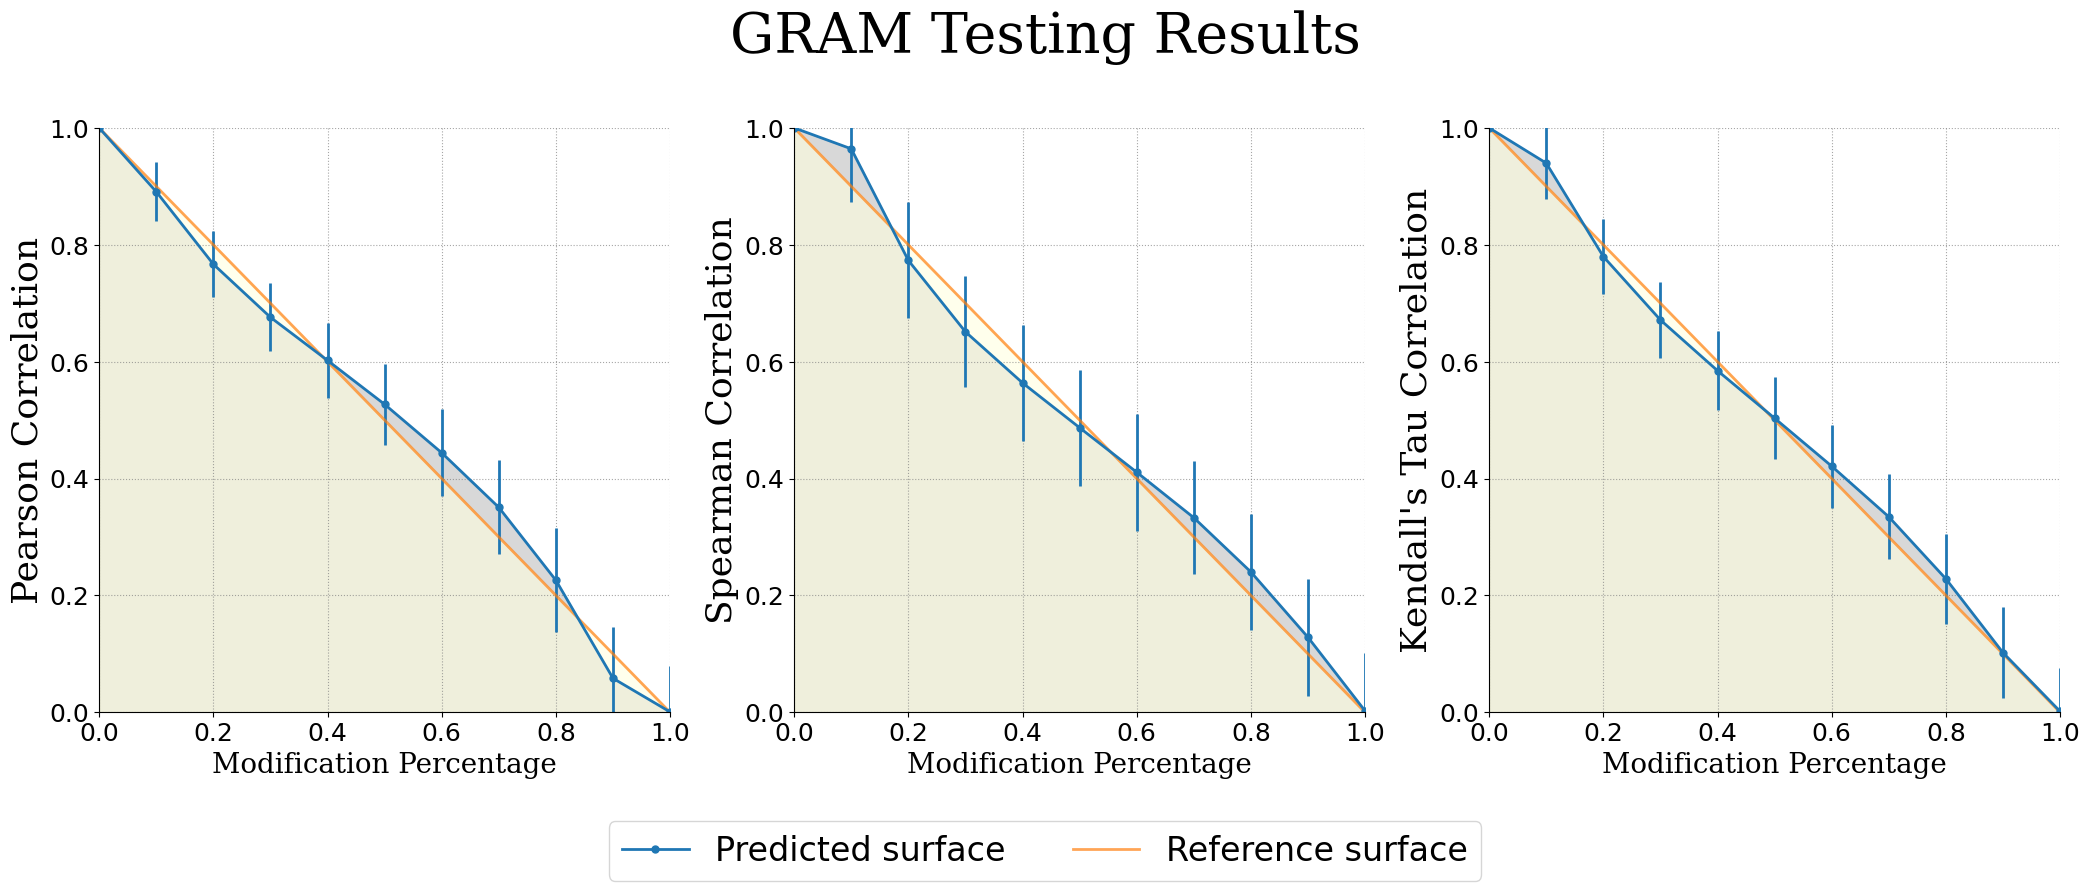

In [ ]:
def plot_gram(correlation, x_percent, C_vector, ax):
    """
    Plots a single subplot with the given data on the provided axis.

    Parameters:
    - ax: the axis to plot on.
    - x_percent: array-like, numeric values for x-axis.
    - C_vector: array-like, reference surface values.
    """

    # B = gram_training(correlation, X, target_area1, target_area2, model)
    y_mean_array, y_std_array = gram_testing(correlation, B, X)

    errorbar_line = ax.errorbar(
        x_percent, y_mean_array, yerr=y_std_array, fmt='-o', color='#1f77b4',
        label='Predicted surface', linewidth=2, markersize=5
    )
    plot_line = ax.plot(
        x_percent, C_vector.flatten(), label='Reference surface', color='#ff7f0e',
        alpha=0.7, linewidth=2
    )
    ax.fill_between(
        x_percent, 0, y_mean_array, where=np.logical_and(min(x_percent) <= x_percent, x_percent <= max(x_percent)),
        color='gray', alpha=0.3
    )
    ax.fill_between(
        x_percent, 0, C_vector, where=np.logical_and(min(x_percent) <= x_percent, x_percent <= max(x_percent)),
        color='lightyellow', alpha=0.6
    )

    ax.set_xlabel("Modification Percentage", fontsize=20, fontname='serif')
    if correlation == "pearson":
        ax.set_ylabel("Pearson Correlation", fontsize=26, fontname='serif')
    elif correlation == "spearman":
        ax.set_ylabel("Spearman Correlation", fontsize=26, fontname='serif')
    elif correlation == "ktau":
        ax.set_ylabel("Kendall's Tau Correlation", fontsize=26, fontname='serif')

    ax.grid(True, linestyle=':', color='gray', alpha=0.7)
    ax.set_facecolor('white')

    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.tick_params(axis='both', which='major', labelsize=18)

    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)

    ax.set_xticks(np.linspace(0, 1, 6))
    ax.set_xticklabels([f"{i:.1f}" for i in np.linspace(0, 1, 6)], fontsize=18)

    return errorbar_line[0], plot_line[0]


x_percent = np.linspace(0, 1, 11)
C_vector = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0])

general_title = "GRAM Testing Results"

fig, axes = plt.subplots(1, 3, figsize=(21, 8))
fig.suptitle(general_title, fontsize=40, fontname='serif')

all_lines = []
all_labels = ['Predicted surface', 'Reference surface']

# Plot on each subplot
lines1 = plot_gram("pearson", x_percent, C_vector, axes[0])
lines2 = plot_gram("spearman", x_percent, C_vector, axes[1])
lines3 = plot_gram("ktau", x_percent, C_vector, axes[2])

# Collect all lines for a common legend
all_lines.extend(lines1)
all_lines.extend(lines2)
all_lines.extend(lines3)

# Create a single legend for all subplots
fig.legend(handles=all_lines[:2], labels=all_labels, loc='lower center', bbox_to_anchor=(0.5, -0.13), ncol=2, fontsize=24)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
